In [19]:
# Setup relative imports
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

import pandas as pd
import numpy as np

from Helper.data import load_data
from Helper.feature_engineering import feature_engineering

np.random.seed(123)

In [13]:
train, test = load_data()

In [20]:
train

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939


In [95]:
test.isna().sum()

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

In [52]:
oneHot_encoder.transform(X.iloc[0:1])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9 stored elements and shape (1, 780501)>

In [98]:
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# split data into variables and response
X = train.drop(['id', 'Listening_Time_minutes'], axis = 1)
Y = train["Listening_Time_minutes"]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(exclude=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', preprocessing.StandardScaler())
])

# Preprocessing for categorical data: One-hot encode
categorical_transformer = Pipeline(steps=[
    ('onehot', preprocessing.OneHotEncoder(drop = 'first'))
])

# Full preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

train_transformed = preprocessor.fit_transform(X)
test_transformed = preprocessor.transform(X)

# TODO: improve imputation
# TODO: are there unknown categories in test data?

## First model

In [107]:
# Fucking weird ass plotting form from https://stackoverflow.com/questions/44443479/how-to-show-loss-values-during-training-in-scikit-learn

import sys
import io
import matplotlib.pyplot as plt

class DisplayLossCurve(object):
  def __init__(self, print_loss=False):
    self.print_loss = print_loss

  """Make sure the model verbose is set to 1"""
  def __enter__(self):
    self.old_stdout = sys.stdout
    sys.stdout = self.mystdout = io.StringIO()
  
  def __exit__(self, *args, **kwargs):
    sys.stdout = self.old_stdout
    loss_history = self.mystdout.getvalue()
    loss_list = []
    for line in loss_history.split('\n'):
      if(len(line.split("loss: ")) == 1):
        continue
      loss_list.append(float(line.split("loss: ")[-1]))
    plt.figure()
    plt.plot(np.arange(len(loss_list)), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    if self.print_loss:
      print("=============== Loss Array ===============")
      print(np.array(loss_list))
      
    return True


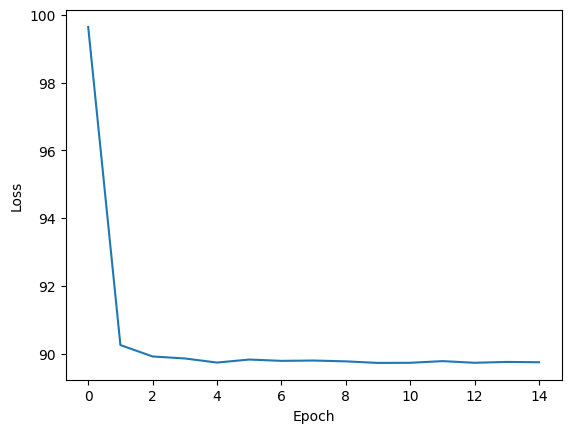

In [110]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(verbose=1, tol = 1e-6)

with DisplayLossCurve():
    model.fit(test_transformed, Y)

In [101]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(test_transformed)
mse = mean_squared_error(Y, y_pred)
print("Final MSE:", mse)

Final MSE: 179.1990913967097
